### Implementation of Residual Attention Network for Image Classification Paper
- Here's my attempt on implementing the paper, **Residual Attention Network for Image Classification Paper** [Link](https://arxiv.org/abs/1704.06904)
- Though, I've written an implementation for this architecture, I can't seem produce a satisfactory results.
- This implementation is likely flawed and I'll move on other papers to implement
- I might return to this paper when I have time again.

In [1]:
%config Completer.use_jedi = False

In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import tensorflow.keras as keras

import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import glob


In [3]:
from PIL import Image
from random import shuffle

In [4]:
import tensorflow_datasets as tfds

In [5]:
import magic

In [6]:
from download_cats_dogs import CatDogDataset

In [7]:
def make_dir(target_dir):
    
    if not os.path.isdir(target_dir):
        print('Making Directory ', target_dir)
        os.mkdir(target_dir)
    else:
        print('Directory already exists')

In [8]:
def remove_non_jpg(target_dir):
    
    filepaths = glob.glob(target_dir + '/**/*', recursive=True)
    count = 0
    total = len(filepaths)
    
    for idx, fp in enumerate(filepaths, start=1):
        print(f'[{idx}/{total}] Processing files.', end='\r')
        if os.path.isfile(fp):
            if magic.from_file(fp).split(' ')[0] != 'JPEG':
                print('Removing file ', fp, end='\r')
                os.remove(fp)
                count += 1
    
    print('')
    print(f'Removed {count} non-jpg images')

In [9]:
#!kaggle datasets download -d jehanbhathena/weather-dataset -p ../dataset/ --unzip

In [10]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)


In [11]:
import PIL

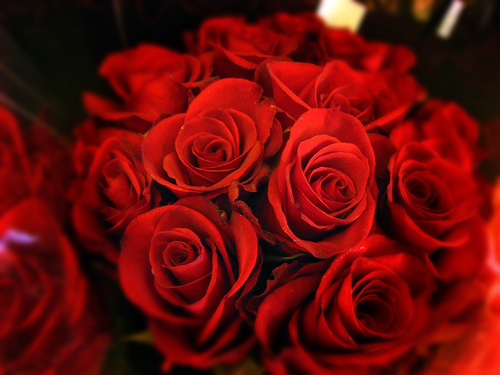

In [12]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))


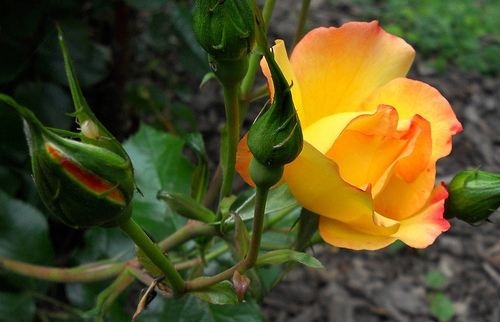

In [13]:
PIL.Image.open(str(roses[1]))


In [14]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [15]:
batch_size = 16
img_height = 224
img_width = 224

tr_ds = keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size, label_mode='int')



Found 3670 files belonging to 5 classes.
Using 2936 files for training.


2021-12-13 04:35:53.056488: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-13 04:35:53.107676: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-13 04:35:53.108015: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-13 04:35:53.108731: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropri

In [16]:
# X,y = next(iter(tr_ds))
# tf.cast(X, dtype=tf.int32)

In [17]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size, label_mode='int')



Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [18]:
tr_augmentation = tf.keras.Sequential([
  keras.layers.RandomFlip("horizontal"),
  keras.layers.RandomRotation(0.2),
  keras.layers.Rescaling(1./255)
])

val_augmentation = tf.keras.Sequential([
  keras.layers.Rescaling(1./255)
])


# tr_ds = tr_ds.map(
#   lambda x, y: (data_augmentation(x, training=True), y))



In [19]:
AUTOTUNE = tf.data.AUTOTUNE

tr_ds = tr_ds.map(lambda x, y: (tr_augmentation(x), y), num_parallel_calls=AUTOTUNE).cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.map(lambda x, y: (val_augmentation(x), y), num_parallel_calls=AUTOTUNE).cache().prefetch(buffer_size=AUTOTUNE)


In [20]:
# X,y = next(iter(val_ds))

# X

In [21]:
def plot_image(image):
    plt.imshow(image)
    plt.axis("off")

In [22]:
class InitialConv(keras.layers.Layer):
    
    def __init__(self, 
                 filters : int, 
                 kernel_size : int, 
                 strides : int,
                 pool_size : int,
                 data_format='channels_last',
                 activation='relu',
                 conv_pad_size=3,
                 pool_pad_size=1,
                 *args, **kwargs):
        
        super(InitialConv, self).__init__(*args, **kwargs)
        
        self.filters = filters
        self.kernel_size = kernel_size
        self.strides = strides

        self.pool_size = pool_size
        self.data_format = data_format
        self.activation = keras.activations.get(activation)
        
        self.conv_pad_size = conv_pad_size
        self.pool_pad_size = pool_pad_size
        
        
    def build(self, input_shape):
        
        conv_pad_shape = (self.conv_pad_size, self.conv_pad_size)
        
        self.zpad_01 = keras.layers.ZeroPadding2D(
            padding=conv_pad_shape,
            data_format=self.data_format,
            input_shape=input_shape)
        
        self.conv = keras.layers.Conv2D(
            filters=self.filters,
            kernel_size=self.kernel_size,
            strides=self.strides,
            padding='valid',
            data_format=self.data_format
        )
        
        self.bnorm = keras.layers.BatchNormalization()
        pool_pad_shape = (self.pool_pad_size, self.pool_pad_size)
        
        self.zpad_02 = keras.layers.ZeroPadding2D(
            padding=pool_pad_shape,
            data_format=self.data_format
        )
        
        self.pool = keras.layers.MaxPool2D(
            pool_size=self.pool_size,
            strides=self.strides, 
            padding='valid'
        )
        
        
    def call(self, x):
        
        x = self.zpad_01(x)
        x = self.conv(x)
        x = self.bnorm(x)
        x = self.activation(x)
        x = self.zpad_02(x)
        x = self.pool(x)
        
        return x
            

In [23]:
class BatchNormConv2D(keras.layers.Layer):
    
    def __init__(self, 
                 filters,
                 kernel_size=1,
                 strides=1,
                 padding_size=0,
                 activation='relu',
                 data_format='channels_last',
                 *args, **kwargs):
        
        super(BatchNormConv2D, self).__init__(*args, **kwargs)
        self.activation = keras.activations.get(activation)
        self.filters = filters
        self.kernel_size = kernel_size
        self.strides = strides
        self.data_format=data_format
        
        self.padding_size = padding_size
                            

    def build(self, input_shape):
        
        self.bnorm = keras.layers.BatchNormalization(
            input_shape=input_shape)
        

        padding_shape = (self.padding_size, self.padding_size)
        
        self.zero_pad = keras.layers.ZeroPadding2D(
            padding=padding_shape,
            data_format=self.data_format
        )
        
        self.conv = keras.layers.Conv2D(
            filters=self.filters,
            kernel_size=self.kernel_size,
            strides=self.strides,
            padding='valid',
            data_format=self.data_format
        )
        
         
    def call(self, x):
        
        x = self.bnorm(x)
        x = self.activation(x)
        x = self.zero_pad(x)
        x = self.conv(x)
        return x




In [24]:
class ResidualBlock(keras.layers.Layer):
    
    def __init__(self, 
                 filters, 
                 strides=1, 
                 data_format='channels_last',
                 *args, **kwargs):
        
        super(ResidualBlock, self).__init__(*args, **kwargs)
        
        self.filters = filters
        
        self.mid_kernel_size = 3
        self.mid_pad_size = 1
        
        self.strides = strides
        self.data_format= data_format
        
    
    def create_projection(self, input_shape):
        return keras.layers.Conv2D(
            filters=self.filters,
            kernel_size=1,
            strides=self.strides,
            data_format=self.data_format
        )
    
        
    def build(self, input_shape):
        
        f1 = self.filters // 4
        f2 = self.filters // 4
        f3 = self.filters 
        
        self.projection = self.create_projection(input_shape=input_shape)
        
        self.bn_conv1 = BatchNormConv2D(filters=f1,
                                        data_format=self.data_format,
                                        input_shape=input_shape)
        
        self.bn_conv2 = BatchNormConv2D(filters=f2, 
                                        kernel_size=self.mid_kernel_size, 
                                        padding_size=self.mid_pad_size,
                                        strides=self.strides,
                                        data_format=self.data_format)
        
        self.bn_conv3 = BatchNormConv2D(filters=f3, 
                                        data_format=self.data_format)
        
        
    def call(self, x):
        
        skip = self.projection(x)
        
        x = self.bn_conv1(x)
        x = self.bn_conv2(x)
        x = self.bn_conv3(x)
        
        return x + skip      
        
            

In [25]:
class ResidualBlocks(keras.models.Model):
    
    def __init__(self, 
                 filters,
                 data_format='channels_last',
                 depth=1, *args, **kwargs):
        
        super(ResidualBlocks, self).__init__(*args, **kwargs)
        
        assert depth > 0, 'trunk_depth must be greater than zero.'
        
        self.data_format = data_format
        self.depth = depth
        self.filters = filters
        
        blocks = self.depth * [
            ResidualBlock(filters=self.filters, 
                          data_format=self.data_format)
        ]
        
        self.main_trunk = keras.Sequential(blocks)


    def call(self, x):
        return self.main_trunk(x)
        
        

In [26]:
class SoftMaskBranch_STG_01(keras.models.Model):
    
    def __init__(self, filters, 
                 num_segments=1,
                 data_format='channels_last', 
                 *args, **kwargs):
        
        super(SoftMaskBranch_STG_01, self).__init__(*args, **kwargs)
                
        self.num_segments = num_segments
        self.data_format = data_format
        self.filters = filters
        
        self.down_sampler = keras.layers.MaxPool2D((3,3), 2, data_format=self.data_format)
        
        self.up_sampler_01 = keras.layers.Resizing(13,13)
        self.up_sampler_02 = keras.layers.Resizing(27,27)
        self.up_sampler_03 = keras.layers.Resizing(56,56)        
        
        self.rb_01 = ResidualBlocks(filters, depth=num_segments, data_format=self.data_format)
        self.rb_02 = ResidualBlocks(filters, depth=num_segments, data_format=self.data_format)
        self.rb_03 = ResidualBlocks(filters, depth=2*num_segments, data_format=self.data_format)
        self.rb_04 = ResidualBlocks(filters, depth=num_segments, data_format=self.data_format)
        self.rb_05 = ResidualBlocks(filters, depth=num_segments, data_format=self.data_format)
        
        self.conv_06 = keras.layers.Conv2D(filters, 
                                           kernel_size=1, 
                                           activation='relu', 
                                           data_format=self.data_format)
        
        self.conv_07 = keras.layers.Conv2D(filters, 
                                           kernel_size=1, 
                                           activation='sigmoid', 
                                           data_format=self.data_format)
        
        self.rb_skip_01 = ResidualBlock(filters, data_format=self.data_format)
        self.rb_skip_02 = ResidualBlock(filters, data_format=self.data_format)
        
        
    def call(self, x):
        
#         tf.debugging.assert_equal(x.shape[1], 56, 'Expecting Tensor with Size (56x56).')
        
        # Input (56x56)
        x = self.down_sampler(x)        # downsampled size = (27x27)
        x = self.rb_01(x)
        
        skip_01 = self.rb_skip_01(x)    
        
        print()
        x = self.down_sampler(x)        # downsampled size = (13x13)
        x = self.rb_02(x)
        skip_02 = self.rb_skip_02(x)    
        
        
        x = self.down_sampler(x)        # downsampled size = (6x6)
        x = self.rb_03(x)
                
        
        x = self.up_sampler_01(x)       # upsampled size = (13x13)
        x += skip_02
        x = self.rb_04(x)
        
        x = self.up_sampler_02(x)       # upsampled size = (27x27)
        x += skip_01
        x = self.rb_05(x)
        
        x = self.up_sampler_03(x)       # upsampled size = (27x27)
        
        x = self.conv_06(x)
        x = self.conv_07(x)
        
        return x
        
        
        

In [27]:
class SoftMaskBranch_STG_02(keras.models.Model):
    
    def __init__(self, filters, 
                 num_segments=1,
                 data_format='channels_last', 
                 *args, **kwargs):
        
        super(SoftMaskBranch_STG_02, self).__init__(*args, **kwargs)
                
        self.num_segments = num_segments
        self.data_format = data_format
        self.filters = filters
        
        self.down_sampler = keras.layers.MaxPool2D((3,3), 2, data_format=self.data_format)
        
        self.up_sampler_01 = keras.layers.Resizing(13,13)
        self.up_sampler_02 = keras.layers.Resizing(28,28)
        
        self.rb_01 = ResidualBlocks(filters, depth=num_segments, data_format=self.data_format)
        self.rb_02 = ResidualBlocks(filters, depth=2*num_segments, data_format=self.data_format)
        self.rb_03 = ResidualBlocks(filters, depth=num_segments, data_format=self.data_format)
        
        self.conv_05 = keras.layers.Conv2D(filters, 
                                           kernel_size=1, 
                                           activation='relu',
                                           data_format=self.data_format)
        
        self.conv_06 = keras.layers.Conv2D(filters, 
                                           kernel_size=1, 
                                           activation='sigmoid',
                                           data_format=self.data_format)
        
        self.rb_skip_01 = ResidualBlock(filters, data_format=self.data_format)
        
        
    def call(self, x):
        
        # Input = (28x28)
#         tf.debugging.assert_equal(x.shape[1], 28, 'Expecting Tensor with Size (28x28).')
        
        x = self.down_sampler(x)        # downsampled size = (13x13)
        x = self.rb_01(x)
        skip_01 = self.rb_skip_01(x)    
        
        x = self.down_sampler(x)        # downsampled size = (13x13)
        x = self.rb_02(x)
        
        x = self.up_sampler_01(x)       # upsampled size = (13x13)
        x += skip_01
        x = self.rb_03(x)
        
        x = self.up_sampler_02(x)       # upsampled size = (28x28)
        
        x = self.conv_05(x)
        x = self.conv_06(x)
        
        return x
        
        
        

In [28]:
class SoftMaskBranch_STG_03(keras.models.Model):
    
    def __init__(self, filters, 
                 num_segments=1,
                 data_format='channels_last', 
                 *args, **kwargs):
        
        super(SoftMaskBranch_STG_03, self).__init__(*args, **kwargs)
                
        self.num_segments = num_segments
        self.data_format = data_format
        self.filters = filters
        
        self.down_sampler = keras.layers.MaxPool2D((3,3), 2)
        
        self.up_sampler_01 = keras.layers.Resizing(14,14)
        
        self.rb_01 = ResidualBlocks(filters, depth=num_segments, data_format=self.data_format)
        self.rb_02 = ResidualBlocks(filters, depth=2*num_segments, data_format=self.data_format)
        self.rb_03 = ResidualBlocks(filters, depth=num_segments, data_format=self.data_format)
        
        self.conv_05 = keras.layers.Conv2D(filters, kernel_size=1, 
                                           activation='relu', 
                                           data_format=self.data_format)
        
        self.conv_06 = keras.layers.Conv2D(filters, kernel_size=1, 
                                           activation='sigmoid',
                                           data_format=self.data_format)
        

        
    def call(self, x):
        
#         tf.debugging.assert_equal(x.shape[1], 14, 'Expects Tensor with Size (14x14).')
        
        x = self.down_sampler(x)        # downsampled size = (6x6)

        x = self.rb_01(x)
        x = self.rb_02(x)
        x = self.rb_03(x)

        
        x = self.up_sampler_01(x)       # upsampled size = (13x13)

        x = self.conv_05(x)
        x = self.conv_06(x)

        
        return x

In [29]:
class ResidualAttentionModule(keras.models.Model):
    
    def __init__(self, filters, stage,
                       pre_post_depth=1, 
                       trunk_depth=2,
                       soft_mask_segments=1,
                       *args, **kwargs):
        
        super(ResidualAttentionModule, self).__init__(*args, **kwargs)
        
        
        assert 0 < stage <= 3, 'Stage must be either 1,2,3'
        
        self.filters = filters
        self.stage = stage
        self.pre_post_depth = pre_post_depth
        self.trunk_depth = trunk_depth
        self.soft_mask_segments = soft_mask_segments
        
        
        self.pre_blocks = ResidualBlocks(filters=self.filters,
                                          depth=self.pre_post_depth)
        
        self.trunk_branch = ResidualBlocks(filters=self.filters, 
                                           depth=self.trunk_depth)
        
        self.post_blocks = ResidualBlocks(filters=self.filters,
                                          depth=self.pre_post_depth)
        
        
        if stage == 1:
            self.soft_mask_branch = SoftMaskBranch_STG_01(filters=self.filters,
                                                          num_segments=self.soft_mask_segments)
            
        elif stage == 2:
            self.soft_mask_branch = SoftMaskBranch_STG_02(filters=self.filters,
                                                          num_segments=self.soft_mask_segments)
            
        elif stage == 3:
            self.soft_mask_branch = SoftMaskBranch_STG_03(filters=self.filters,
                                                          num_segments=self.soft_mask_segments)
            
            
    def call(self, x):
        
        x = self.pre_blocks(x)
 
        x_trunk = self.trunk_branch(x)
        x_mask = self.soft_mask_branch(x)
        x_masked = tf.math.multiply(x_trunk, x_mask)
        x = tf.math.add(x_trunk, x_masked)
        x = self.post_blocks(x)
        
        return x
        
        


In [30]:
model_root = '../model'
model_dir = '../model/residual_attention_v7'

make_dir(model_root)
make_dir(model_dir)

Directory already exists
Directory already exists


In [32]:
X,y = next(iter(tr_ds))

2021-12-13 04:35:59.357375: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [36]:

N_CLASSES = 5

model = keras.Sequential([

    InitialConv(filters=64, kernel_size=7,strides=2, pool_size=3, input_shape=[224,224,3]),
    ResidualAttentionModule(filters=256, stage=1),
    ResidualBlock(filters=512, strides=2),
    ResidualAttentionModule(filters=512, stage=2),
    ResidualBlock(filters=1024, strides=2),
    ResidualAttentionModule(filters=1024, stage=3),
    ResidualBlock(filters=2048, strides=1),
    ResidualBlock(filters=2048, strides=1),
    ResidualBlock(filters=2048, strides=1),
    ResidualBlock(filters=2048, strides=2),
    keras.layers.AveragePooling2D((7,7), strides=1),
    keras.layers.Dropout(0.2),
    keras.layers.Flatten(),
    keras.layers.Dense(1000, 'relu'),

    keras.layers.Dense(N_CLASSES)
])



In [34]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
model_path = os.path.join(model_dir, 'model.h5')
model_cb = ModelCheckpoint(model_path, monitor='val_accuracy', save_best_only=True, save_weights_only=True)
es_cb = EarlyStopping(monitor='val_accuracy', patience=10)

model.compile(optimizer=keras.optimizers.Adam(learning_rate=3e-4),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics='accuracy')

num_epochs = 30
history = model.fit(tr_ds, validation_data=val_ds, epochs=num_epochs, callbacks=[model_cb, es_cb])

In [ ]:
hist_data4 = history.history.copy()

In [36]:
hist_data3 = history.history.copy()

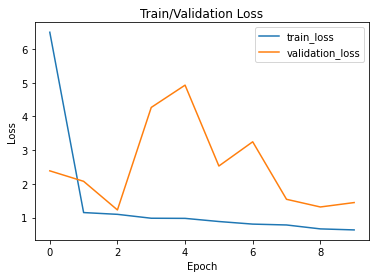

In [37]:
plt.plot(hist_data3['loss'], label='train_loss')
plt.plot(hist_data3['val_loss'], label='validation_loss')
plt.legend()
plt.title('Train/Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

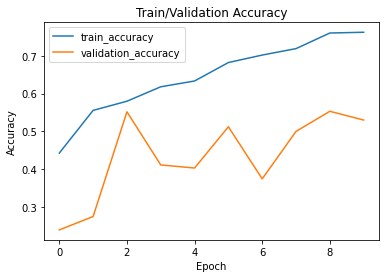

In [38]:
plt.plot(hist_data3['accuracy'], label='train_accuracy')
plt.plot(hist_data3['val_accuracy'], label='validation_accuracy')
plt.legend()
plt.title('Train/Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

In [49]:
hist_data2 = history.history.copy()

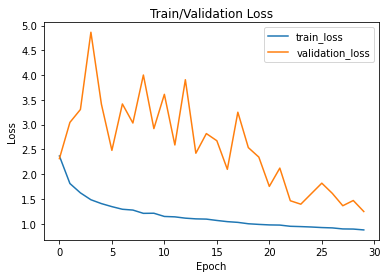

In [50]:
plt.plot(hist_data2['loss'], label='train_loss')
plt.plot(hist_data2['val_loss'], label='validation_loss')
plt.legend()
plt.title('Train/Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

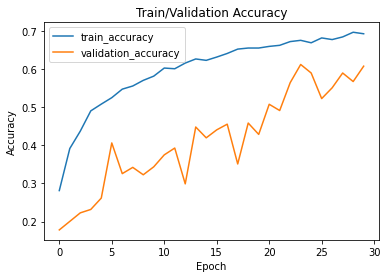

In [51]:
plt.plot(hist_data2['accuracy'], label='train_accuracy')
plt.plot(hist_data2['val_accuracy'], label='validation_accuracy')
plt.legend()
plt.title('Train/Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

In [40]:
hist_data = history.history.copy()

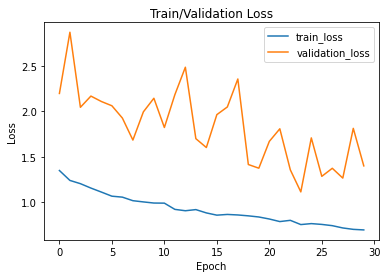

In [36]:
plt.plot(hist_data['loss'], label='train_loss')
plt.plot(hist_data['val_loss'], label='validation_loss')
plt.legend()
plt.title('Train/Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

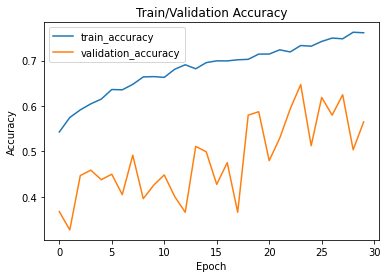

In [39]:
plt.plot(hist_data['accuracy'], label='train_accuracy')
plt.plot(hist_data['val_accuracy'], label='validation_accuracy')
plt.legend()
plt.title('Train/Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

In [41]:
np.max(hist_data['val_accuracy'])

0.6472346782684326

In [24]:
# class SoftMaskBranch()

In [56]:
make_dir('../dataset/resized_dataset')

![Residual Unit](images/residual_unit.png)

In [12]:
from resnet_50 import building_block, block_layer

![Architecture](images/resnet_attn_architecture.png)

![Parameter Reference](images/layer_parameter_table.png)